
# College Event Feedback Analysis — Internship Project

This notebook walks you **step-by-step** through the full workflow:
1) Setup & installations  
2) Load the CSV (from Google Form or the sample file)  
3) Clean & transform data  
4) Exploratory analysis (ratings, top events, trends)  
5) Sentiment analysis on comments (TextBlob + VADER)  
6) Insights & recommendations export



In [3]:

!pip -q install pandas numpy matplotlib seaborn textblob vaderSentiment wordcloud emoji -U

import textblob
textblob.download_corpora.download_all()


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.



## 1) Load your data



In [5]:

import pandas as pd
from io import StringIO
from google.colab import files

uploaded = files.upload()  # Choose your CSV
csv_name = next(iter(uploaded))  # first uploaded file
data = pd.read_csv(StringIO(uploaded[csv_name].decode('utf-8')))
data.head()


Saving sample_student_feedback.csv to sample_student_feedback.csv


,Timestamp,Event Name,Department,Event Type,Rating,Would Recommend,Comment,Duration (hours),Attendance
0,2025-07-04 13:00:00,Alumni Talk Series,Mechanical,expo,4,Yes,Great organization and helpful volunteers.,2.6,20
1,2025-02-04 15:00:00,Workshop: Python for Data,MBA,workshop,5,Yes,Loved the speaker and the Q&A session.,2.9,153
2,2025-03-18 12:00:00,Tech Fest 2025,ECE,expo,4,Yes,Loved the speaker and the Q&A session.,1.8,20
3,2025-06-10 16:00:00,Workshop: Python for Data,Biotech,workshop,4,Yes,Great organization and helpful volunteers.,1.2,111
4,2025-04-12 18:00:00,Cultural Night,CSE,expo,2,Yes,Session started late; needs better time manage...,1.9,111


In [6]:

# OPTIONAL: Load from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = "/content/drive/MyDrive/path/to/your/student_feedback.csv"
# import pandas as pd
# data = pd.read_csv(csv_path)
# data.head()



## 2) Clean & normalize columns
This will:
- Standardize column names
- Parse dates
- Trim whitespace and unify categories
- Handle missing values


In [7]:

import numpy as np

df = data.copy()

# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace('[^a-z0-9]+','_', regex=True)

# Friendly renames to a common schema
rename_map = {
    'timestamp': 'timestamp',
    'event_name': 'event_name',
    'department': 'department',
    'event_type': 'event_type',
    'rating': 'rating',
    'would_recommend': 'would_recommend',
    'comment': 'comment',
    'duration_hours': 'duration_hours',
    'duration_(hours)': 'duration_hours',
    'attendance': 'attendance',
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Parse timestamp if present
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Coerce numeric
for col in ['rating','duration_hours','attendance']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Trim strings
for col in ['event_name','department','event_type','would_recommend','comment']:
    if col in df.columns:
        df[col] = df[col].astype('string').str.strip()

# Unify categories
if 'would_recommend' in df.columns:
    df['would_recommend'] = df['would_recommend'].str.lower().map({'yes':'Yes','no':'No'}).fillna(df['would_recommend'])

if 'event_type' in df.columns:
    df['event_type'] = df['event_type'].str.lower()

# Handle missing ratings/comments
if 'rating' in df.columns:
    df = df[df['rating'].between(1,5)]

df = df.drop_duplicates()

print(df.shape)
df.head()


(220, 9)


,timestamp,event_name,department,event_type,rating,would_recommend,comment,duration_hours_,attendance
0,2025-07-04 13:00:00,Alumni Talk Series,Mechanical,expo,4,Yes,Great organization and helpful volunteers.,2.6,20
1,2025-02-04 15:00:00,Workshop: Python for Data,MBA,workshop,5,Yes,Loved the speaker and the Q&A session.,2.9,153
2,2025-03-18 12:00:00,Tech Fest 2025,ECE,expo,4,Yes,Loved the speaker and the Q&A session.,1.8,20
3,2025-06-10 16:00:00,Workshop: Python for Data,Biotech,workshop,4,Yes,Great organization and helpful volunteers.,1.2,111
4,2025-04-12 18:00:00,Cultural Night,CSE,expo,2,Yes,Session started late; needs better time manage...,1.9,111



## 3) Exploratory data analysis (EDA)
Let's answer:
- Rating distribution  
- Average rating by **event**, **event type**, **department**  
- Recommendation rate (Yes %)  



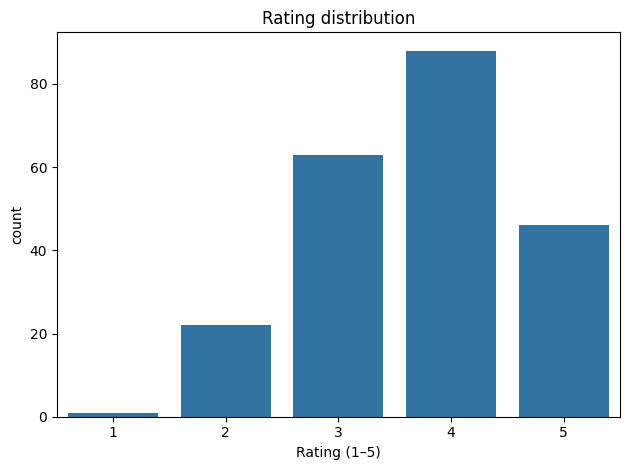

Top 10 events by average rating:
event_name
Hackathon Sprint             3.869565
Cultural Night               3.837838
Tech Fest 2025               3.800000
Career Fair                  3.777778
Alumni Talk Series           3.678571
Workshop: Python for Data    3.611111
Robotics Expo                3.550000
Seminar: AI Ethics           3.500000
Name: rating, dtype: float64

Average rating by event type:
event_type
tech_fest      4.285714
cultural       4.090909
workshop       3.937500
talk           3.750000
competition    3.633333
seminar        3.441176
expo           3.433333
fair           3.370370
Name: rating, dtype: float64

Average rating by department:
department
IT            3.851852
ECE           3.800000
MBA           3.791667
EEE           3.766667
Biotech       3.736842
Civil         3.640000
Mechanical    3.600000
CSE           3.461538
Name: rating, dtype: float64

Overall 'Would Recommend' rate: 66.8%


In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

# Rating distribution
plt.figure()
sns.countplot(x='rating', data=df)
plt.title('Rating distribution')
plt.xlabel('Rating (1–5)')
plt.tight_layout()
plt.show()

# Average rating by event
top_events = (df.groupby('event_name')['rating']
                .mean()
                .sort_values(ascending=False)
                .head(10))
print("Top 10 events by average rating:")
print(top_events)

# Average by event type and department
if 'event_type' in df.columns:
    print("\nAverage rating by event type:")
    print(df.groupby('event_type')['rating'].mean().sort_values(ascending=False))

if 'department' in df.columns:
    print("\nAverage rating by department:")
    print(df.groupby('department')['rating'].mean().sort_values(ascending=False))

# Recommend rate
if 'would_recommend' in df.columns:
    rec_rate = (df['would_recommend'] == 'Yes').mean() * 100
    print(f"\nOverall 'Would Recommend' rate: {rec_rate:.1f}%")



## 4) Sentiment analysis on comments



In [9]:

import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def clean_text(s):
    if pd.isna(s): return s
    s = re.sub(r"http\S+|www\S+"," ", s)  # URLs
    s = re.sub(r"@[\w_]+"," ", s)         # mentions
    s = re.sub(r"#[\w_]+"," ", s)         # hashtags
    s = re.sub(r"[^\w\s']", " ", s)      # punctuation
    s = re.sub(r"\s+"," ", s).strip()
    return s

if 'comment' in df.columns:
    df['comment_clean'] = df['comment'].apply(clean_text)

    # TextBlob
    df['tb_polarity'] = df['comment_clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else np.nan)
    df['tb_subjectivity'] = df['comment_clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity if pd.notna(x) else np.nan)

    # VADER
    analyzer = SentimentIntensityAnalyzer()
    df['vader'] = df['comment_clean'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'] if pd.notna(x) else np.nan)

    def label_from_vader(v):
        if pd.isna(v): return np.nan
        if v >= 0.05: return 'positive'
        if v <= -0.05: return 'negative'
        return 'neutral'

    df['sentiment'] = df['vader'].apply(label_from_vader)

    print(df[['comment','tb_polarity','vader','sentiment']].head())
else:
    print("No 'comment' column found.")


                                             comment  tb_polarity   vader  \
0         Great organization and helpful volunteers.     0.800000  0.7845   
1             Loved the speaker and the Q&A session.     0.700000  0.5994   
2             Loved the speaker and the Q&A session.     0.700000  0.5994   
3         Great organization and helpful volunteers.     0.800000  0.7845   
4  Session started late; needs better time manage...     0.122222  0.6705   

  sentiment  
0  positive  
1  positive  
2  positive  
3  positive  
4  positive  



## 5) Compare sentiment vs. ratings



In [10]:

if 'rating' in df.columns and 'vader' in df.columns:
    corr = df[['rating','tb_polarity','vader']].corr(numeric_only=True)
    print("Correlation matrix (rating vs sentiment):\n", corr)

    if 'event_type' in df.columns:
        print("\nAverage VADER by event type:")
        print(df.groupby('event_type')['vader'].mean().sort_values(ascending=False))

    if 'sentiment' in df.columns:
        print("\nRating by sentiment label:")
        print(df.groupby('sentiment')['rating'].mean().sort_values(ascending=False))


Correlation matrix (rating vs sentiment):
                rating  tb_polarity     vader
rating       1.000000     0.372060  0.467221
tb_polarity  0.372060     1.000000  0.418727
vader        0.467221     0.418727  1.000000

Average VADER by event type:
event_type
tech_fest      0.653695
talk           0.592054
cultural       0.563514
expo           0.525280
workshop       0.513081
seminar        0.485426
fair           0.395033
competition    0.366583
Name: vader, dtype: float64

Rating by sentiment label:
sentiment
positive    3.912088
negative    2.750000
neutral     2.714286
Name: rating, dtype: float64



## 6) Frequent themes (n-grams) & word cloud (optional)


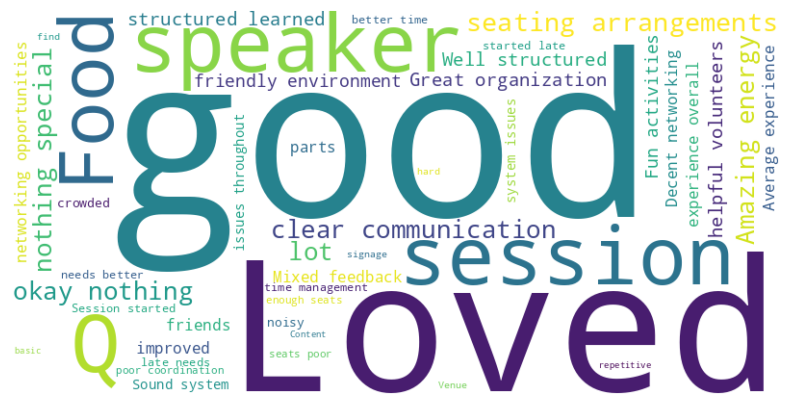

In [12]:

from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

if 'comment_clean' in df.columns:
    text = " ".join(df['comment_clean'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white",
                          stopwords=STOPWORDS).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
else:
    print("Column 'comment_clean' not found in dataframe.")




## 7) Auto-insights & recommendations



In [13]:

lines = []

if 'event_name' in df.columns and 'rating' in df.columns:
    top3 = (df.groupby('event_name')['rating'].mean().sort_values(ascending=False).head(3))
    worst3 = (df.groupby('event_name')['rating'].mean().sort_values().head(3))

    lines.append("Top 3 events by average rating:")
    for k,v in top3.items():
        lines.append(f" - {k}: {v:.2f}")

    lines.append("\nBottom 3 events by average rating:")
    for k,v in worst3.items():
        lines.append(f" - {k}: {v:.2f}")

if 'event_type' in df.columns:
    et = df.groupby('event_type')['rating'].mean().sort_values(ascending=False)
    lines.append("\nBest-rated event types: " + ", ".join([f"{k} ({v:.2f})" for k,v in et.head(3).items()]))

if 'sentiment' in df.columns:
    sent_counts = df['sentiment'].value_counts(dropna=True, normalize=True) * 100
    lines.append("\nSentiment split: " + ", ".join([f"{k}: {v:.1f}%" for k,v in sent_counts.items()]))

# Simple recommendations from common negatives
recs = []
if 'comment_clean' in df.columns and 'sentiment' in df.columns:
    neg = df.loc[df['sentiment']=='negative','comment_clean'].str.lower().fillna("")
    key_flags = {
        "crowd": "Plan larger venues or cap registrations to avoid overcrowding.",
        "noisy": "Improve sound checks and acoustics; designate quiet zones.",
        "late": "Enforce stricter schedules and buffer times for setup.",
        "sound": "Test audio equipment earlier; keep backup microphones.",
        "seat": "Increase seating capacity or stagger sessions.",
        "basic": "Adjust difficulty level and share pre-event prerequisites.",
        "venue": "Share clearer directions and signage beforehand."
    }
    for k,msg in key_flags.items():
        if neg.str.contains(k).mean() > 0.02:  # appears in >2% of negative comments
            recs.append("• " + msg)

if recs:
    lines.append("\nRecommendations:")
    lines.extend(recs)

summary = "\n".join(lines)
print(summary if lines else "Not enough fields to compute insights.")


Top 3 events by average rating:
 - Hackathon Sprint: 3.87
 - Cultural Night: 3.84
 - Tech Fest 2025: 3.80

Bottom 3 events by average rating:
 - Seminar: AI Ethics: 3.50
 - Robotics Expo: 3.55
 - Workshop: Python for Data: 3.61

Best-rated event types: tech_fest (4.29), cultural (4.09), workshop (3.94)

Sentiment split: positive: 82.7%, negative: 10.9%, neutral: 6.4%

Recommendations:
• Plan larger venues or cap registrations to avoid overcrowding.
• Improve sound checks and acoustics; designate quiet zones.
• Test audio equipment earlier; keep backup microphones.
• Increase seating capacity or stagger sessions.
• Adjust difficulty level and share pre-event prerequisites.
• Share clearer directions and signage beforehand.



## 8) Export cleaned data and features


In [14]:

out_csv = "cleaned_feedback_with_sentiment.csv"
df.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Saved: cleaned_feedback_with_sentiment.csv
